In [9]:
%env PURE_PYTHON True
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from BTrees.OOBTree import OOBTree
import numpy as np
from collections import Counter
#from scipy import stats
import pandas as pd
import pprint
import timeit

CHUNKS_SIZE = 10000
KEY_LENGTH = 8
ALPHABET = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

env: PURE_PYTHON=True


In [114]:
_debug_random_sampling = []
USE_CACHE = False

In [115]:
from collections import Counter
import numpy as np
from BTrees.OOBTree import OOBTree



class WALKING_TECHNIQUE:
    RANDOM = 'random'
    RANDOM_WITH_TEST = 'random_with_test'
    OLKEN_EARLY_ABORT = 'olken_early_abort'
    DISTRIBUTION_ORIENTED = 'distribution_oriented'


class OOBTreeExt(OOBTree):

    def __init__(self):
        super(OOBTreeExt, self).__init__()
        self.walking_path_to_fanout_distribution = {}

    def random_sampling(self, k, how_to_walk):
        self.walking_path_to_fanout_distribution = {}
        all_accept_reject_measures = {
            'accept': [],
            'reject': [],
            'revisited_paths': Counter()
        }

        k = min(len(self), k)
        sampled_values = []
        all_walking_paths_set = set()
        while len(sampled_values) < k:
            sampled_value, walking_path, acc_rej_test_acceptance_prob = \
                self._get_value_and_path_by_random_walk_from_node(node=self,
                    how_to_walk=how_to_walk)

            if _this_value_was_sampled_already(walking_path, all_walking_paths_set):
                all_accept_reject_measures['revisited_paths'][str(walking_path)] += 1
                continue

            accept_reject_measures = {
                'path': walking_path,
                'value': sampled_value,
                'acceptance_prob': acc_rej_test_acceptance_prob
            }

            if how_to_walk == WALKING_TECHNIQUE.RANDOM_WITH_TEST and not _accept_reject_test_pass(
                    acc_rej_test_acceptance_prob):
                all_accept_reject_measures['reject'].append(accept_reject_measures)
                continue

            all_accept_reject_measures['accept'].append(accept_reject_measures)

            all_walking_paths_set.add(str(walking_path))
            sampled_values.append(sampled_value)

        add_to_debug_global(locals())

        return sampled_values

    def _get_value_and_path_by_random_walk_from_node(self, node, how_to_walk):
        walking_path = []
        current_node = node
        acc_rej_test_acceptance_prob = 1
        acc_rej_test_max_fan_out = None

        while not isinstance(current_node, self._bucket_type):
            all_sizes = None
            if how_to_walk == WALKING_TECHNIQUE.RANDOM_WITH_TEST:
                acc_rej_test_max_fan_out = self.max_internal_size
                next_random_step = np.random.randint(low=0, high=current_node.size)
            elif how_to_walk == WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED:
                next_random_step, all_sizes = self._random_next_move_respect_fanout_prob(current_node, walking_path)
            else:
                assert how_to_walk == WALKING_TECHNIQUE.RANDOM
                next_random_step = np.random.randint(low=0, high=current_node.size)
            
            last_node_size = current_node.size
            current_node = current_node._data[next_random_step].child

            if how_to_walk == WALKING_TECHNIQUE.RANDOM_WITH_TEST:
                acc_rej_test_acceptance_prob *= (current_node.size / acc_rej_test_max_fan_out)

            walking_path.append((next_random_step, last_node_size, acc_rej_test_max_fan_out, all_sizes))

        next_random_step = np.random.randint(low=0, high=current_node.size)
        walking_path.append((next_random_step, current_node.size, acc_rej_test_max_fan_out, all_sizes))

        leaf = current_node._keys
        return leaf[next_random_step], walking_path, acc_rej_test_acceptance_prob

    def _get_path_to_bucket_of_value(self, key):
        path = []
        current_node = self._data

        index = self._search(key)
        # TODO: im not sure what _search('M') return 0, check it
        if index >= 0:  # TODO: else?
            if isinstance(self._data[index].child, self._bucket_type):
                index_in_leaf = _find_first_greather_value_in_list(self._data[index].child._values,
                    key)
                return [index, index_in_leaf]
            path_from_child = self._data[index].child._get_path_to_bucket_of_value(key)
            path_from_child = [index] + path_from_child
        else:
            raise  # TODO!
        return path_from_child


    def _random_next_move_respect_fanout_prob(self, current_node, walking_path):
        all_sizes = None
        walking_path_str = str(walking_path)
        if walking_path_str in self.walking_path_to_fanout_distribution and USE_CACHE:
            node_distribution = self.walking_path_to_fanout_distribution[walking_path_str]
        else:
            all_sizes = np.array([node.child.size for node in current_node._data])
            node_distribution = all_sizes / sum(all_sizes)
            self.walking_path_to_fanout_distribution[walking_path_str] = node_distribution

        return np.random.choice(current_node.size, p=node_distribution), all_sizes


def _find_first_greather_value_in_list(sorted_list, key):
    values_greater_than_key = [index for index, val in enumerate(sorted_list) if val >= key]
    if values_greater_than_key:
        return values_greater_than_key[0]
    return len(sorted_list) - 1


def add_to_debug_global(all_vars):
    global _debug_random_sampling
    _debug_random_sampling.append({
        'params': {
            'k': all_vars['k'],
            'how_to_walk': all_vars['how_to_walk'],
        },
        'all_accept_reject_measures': all_vars['all_accept_reject_measures']
    })


def _this_value_was_sampled_already(walking_path, all_walking_paths_set):
    return str(walking_path) in all_walking_paths_set


def _get_max_fan_out_for_(current_node):
    return np.max([node_data.child.size for node_data in current_node._data])


def _accept_reject_test_pass(acceptance_prob):
    rand_num = np.random.random_sample()
    return rand_num < acceptance_prob



In [74]:
def generate_btree_index_x_values_with_dist(num_of_values, disired_prefix_to_percent_dist, my_index=None):
    my_index = my_index if my_index is not None else OOBTreeExt()
    for prefix, amount_percent in disired_prefix_to_percent_dist.items():
        amount = int(num_of_values * amount_percent)
        my_index = insert_to_index_random(my_index, amount, prefix)

    return my_index


def insert_to_index_random(my_index, amount, prefix=''):
    amount_in_iteration = min(CHUNKS_SIZE, amount)
    print('generating %s values, chunk of %s, with prefix=\'%s\'' %(amount, amount_in_iteration, prefix))

    proceed = 0
    for i in range(0, amount, amount_in_iteration):
        alphabet = list(ALPHABET)
        np_alphabet = np.array(alphabet)
        np_codes = np.random.choice(np_alphabet, [amount_in_iteration, KEY_LENGTH])
        my_index.update({
            prefix + ''.join(np_codes[i]): "".join(np_codes[i])
            for i in range(len(np_codes))
        })

        proceed += amount_in_iteration
        if (proceed % 150000) == 0:
            print('done generating %s values' % (proceed))
    return my_index


In [43]:
import datetime
print(datetime.datetime.now())
prefix_to_percent = {
    'gggg': 0.25,
    'hhhh': 0.15,
    'mmmm': 0.10,
    'rrrr': 0.03,
    '': 0.47
}
num_of_values = 1_000_000
my_index = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExt())
print(datetime.datetime.now())

2021-01-15 11:51:33.868670
generating 250000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
generating 150000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
generating 100000 values, chunk of 10000, with prefix='mmmm'
generating 30000 values, chunk of 10000, with prefix='rrrr'
generating 470000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
2021-01-15 11:52:23.747010


In [44]:
def _get_height(tree):
    h = 1
    node = tree._data[0].child
    while not isinstance(node, tree._bucket_type):
        node = node._data[0].child
        h += 1
    return h + 1

In [45]:
_get_height(my_index)

3

In [46]:
sampled = my_index.random_sampling(10, WALKING_TECHNIQUE.RANDOM)

In [47]:
sampled

['WQVjUIbX',
 'ggggKNXZnVXw',
 'hhiHDwHx',
 'hhhhvKYlgweE',
 'TTrMyMdf',
 'ggggkJNGnDLo',
 'mmmmNnRfeEGj',
 'ggggHhlaPgML',
 'cBtfwqda',
 'gggggvyuUAFm']

In [51]:
_debug_random_sampling[-1]['all_accept_reject_measures']['accept']

[{'path': [(66, 288, None), (2, 202, None), (12, 16, None)],
  'value': 'WQVjUIbX',
  'acceptance_prob': 1},
 {'path': [(103, 288, None), (101, 202, None), (3, 17, None)],
  'value': 'ggggKNXZnVXw',
  'acceptance_prob': 1},
 {'path': [(202, 288, None), (27, 135, None), (5, 16, None)],
  'value': 'hhiHDwHx',
  'acceptance_prob': 1},
 {'path': [(197, 288, None), (89, 131, None), (1, 23, None)],
  'value': 'hhhhvKYlgweE',
  'acceptance_prob': 1},
 {'path': [(57, 288, None), (93, 141, None), (10, 26, None)],
  'value': 'TTrMyMdf',
  'acceptance_prob': 1},
 {'path': [(135, 288, None), (155, 183, None), (3, 19, None)],
  'value': 'ggggkJNGnDLo',
  'acceptance_prob': 1},
 {'path': [(224, 288, None), (51, 142, None), (7, 17, None)],
  'value': 'mmmmNnRfeEGj',
  'acceptance_prob': 1},
 {'path': [(100, 288, None), (61, 193, None), (9, 16, None)],
  'value': 'ggggHhlaPgML',
  'acceptance_prob': 1},
 {'path': [(78, 288, None), (61, 219, None), (2, 18, None)],
  'value': 'cBtfwqda',
  'acceptance_p

In [254]:
print(datetime.datetime.now())
num_of_values = 4_000_000
my_index_4m = generate_btree_index_x_values_with_dist(num_of_values, prefix_to_percent, OOBTreeExt())
print(datetime.datetime.now())

2021-01-15 15:49:49.840274
generating 1000000 values, chunk of 10000, with prefix='gggg'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
generating 600000 values, chunk of 10000, with prefix='hhhh'
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
generating 400000 values, chunk of 10000, with prefix='mmmm'
done generating 150000 values
done generating 300000 values
generating 120000 values, chunk of 10000, with prefix='rrrr'
generating 1880000 values, chunk of 10000, with prefix=''
done generating 150000 values
done generating 300000 values
done generating 450000 values
done generating 600000 values
done generating 750000 values
done generating 900000 values
done generating 1050000 values
done generating 1200000 values
done generating 1350000 values
done generating 1500000 values
done g

In [82]:
sampled = my_index_4m.random_sampling(10, WALKING_TECHNIQUE.RANDOM)

In [84]:
# sampling_random = _debug_random_sampling[-2]['all_accept_reject_measures']['accept']
# sampling_random

In [255]:
sampled2 = my_index_4m.random_sampling(10, WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED)

In [256]:
sampling_ditribution = _debug_random_sampling[-1]['all_accept_reject_measures']['accept']

In [257]:
p=1
for step in sampling_ditribution[0]['path']:
    chosen = step[0]
    sizes = step[3]
    curr_p = sizes[chosen]/sizes.sum()
    p *= curr_p
    print (f'ratio: {sizes[chosen]}/{sizes.sum()}={curr_p}, p={p:.15f}')

ratio: 134/1155=0.11601731601731602, p=0.116017316017316
ratio: 186/22613=0.008225357095476053, p=0.000954283853501
ratio: 25/3903=0.006405329233922624, p=0.000006112502264
ratio: 16/3903=0.004099410709710479, p=0.000000025057657


In [258]:
p=1
for step in sampling_ditribution[1]['path']:
    chosen = step[0]
    sizes = step[3]
    if sizes is None:
        print('None')
        continue
    curr_p = sizes[chosen]/sizes.sum()
    p *= curr_p
    print (f'ratio: {sizes[chosen]}/{sizes.sum()}={curr_p}, p={p:.15f}')

ratio: 237/1155=0.2051948051948052, p=0.205194805194805
ratio: 210/39782=0.005278769292644914, p=0.001083176036673
ratio: 24/4361=0.005503324925475808, p=0.000005961069681
ratio: 24/4361=0.005503324925475808, p=0.000000032805703


In [108]:
sampling_ditribution[1]['path']

[(6, 7, None, None),
 (65,
  212,
  None,
  array([151, 150, 147, 157, 163, 154, 154, 162, 152, 156, 162, 167, 162,
         174, 185, 189, 172, 180, 158, 165, 157, 161, 169, 165, 148, 151,
         161, 159, 164, 178, 169, 156, 159, 163, 168, 169, 176, 166, 177,
         164, 173, 183, 181, 175, 180, 188, 162, 173, 162, 155, 177, 172,
         180, 183, 171, 187, 178, 178, 167, 166, 176, 169, 175, 189, 174,
         125, 135, 146, 203, 206, 145, 146, 152, 145, 146, 147, 145, 154,
         222, 221, 216, 228, 215, 220, 227, 238, 211, 221, 204, 217, 213,
         207, 212, 208, 149, 148, 152, 159, 147, 157, 154, 170, 167, 162,
         163, 170, 161, 169, 165, 158, 168, 157, 166, 159, 169, 147, 155,
         222, 228, 142, 150, 154, 149, 175, 169, 164, 180, 219, 220, 214,
         240, 245, 250, 224, 234, 234, 226, 227, 236, 237, 239, 236, 125,
         189, 194, 188, 197, 215, 212, 209, 207, 207, 204, 206, 206, 209,
         194, 218, 205, 206, 203, 197, 217, 207, 203, 200, 200, 214, 1

In [120]:
# import pickle
# print(datetime.datetime.now())
# with open('my_index4mvalues.pickle', 'wb') as handle:
#     pickle.dump(list(my_index_4m.values()), handle, protocol=pickle.HIGHEST_PROTOCOL)
# print(datetime.datetime.now())

2021-01-15 13:09:41.056916
2021-01-15 13:09:47.359804


In [121]:
# print(datetime.datetime.now())
# with open('my_index4mvalues.pickle', 'rb') as handle:
#     my_index_values = pickle.load(handle)
# print(datetime.datetime.now())

2021-01-15 13:11:21.457550
2021-01-15 13:11:22.018432


In [123]:
# print(datetime.datetime.now())
# my_index_4m = OOBTreeExt()
# my_index_4m.update({x:x for x in my_index_values})
# print(datetime.datetime.now())

2021-01-15 13:12:03.130191
2021-01-15 13:15:41.681593


In [259]:
sampled2 = my_index_4m.random_sampling(2000, WALKING_TECHNIQUE.DISTRIBUTION_ORIENTED)

In [260]:
sampling_ditribution = _debug_random_sampling[-1]['all_accept_reject_measures']['accept']

In [261]:
all_p = []
all_p_if_random = []
for sampled_stats in sampling_ditribution:
    p=1
    p_if_random = 1
    sampled_path = sampled_stats['path']
    for step in sampled_path:
        chosen = step[0]
        chosen_from = step[1]
        p_if_random *= 1/chosen_from
        sizes = step[3]
        curr_p = sizes[chosen]/sizes.sum()
        p *= curr_p
        print (f'ratio: {sizes[chosen]}/{sizes.sum()}={curr_p}, p={p:.15f} , p_if_random={p_if_random:.15f}')
    all_p.append(p)
    all_p_if_random.append(p_if_random)
    print('')

ratio: 169/1155=0.14632034632034632, p=0.146320346320346 , p_if_random=0.142857142857143
ratio: 155/25637=0.006045949214026602, p=0.000884645382832 , p_if_random=0.000845308537616
ratio: 21/3230=0.006501547987616099, p=0.000005751564409 , p_if_random=0.000005453603468
ratio: 30/3230=0.009287925696594427, p=0.000000053420103 , p_if_random=0.000000259695403

ratio: 237/1155=0.2051948051948052, p=0.205194805194805 , p_if_random=0.142857142857143
ratio: 191/39782=0.004801166356643708, p=0.000985174395259 , p_if_random=0.000602772754671
ratio: 23/3944=0.0058316430020283975, p=0.000005745185368 , p_if_random=0.000003155878297
ratio: 21/3944=0.005324543610547667, p=0.000000030590490 , p_if_random=0.000000137212100

ratio: 169/1155=0.14632034632034632, p=0.146320346320346 , p_if_random=0.142857142857143
ratio: 156/25637=0.006084955337988064, p=0.000890352772398 , p_if_random=0.000845308537616
ratio: 18/3307=0.005442999697611128, p=0.000004846189871 , p_if_random=0.000005418644472
ratio: 18/330

ratio: 30/3078=0.009746588693957114, p=0.000007250789094 , p_if_random=0.000007352400559
ratio: 26/3078=0.008447043534762833, p=0.000000061247731 , p_if_random=0.000000245080019

ratio: 134/1155=0.11601731601731602, p=0.116017316017316 , p_if_random=0.142857142857143
ratio: 152/22613=0.006721797196303012, p=0.000779844869528 , p_if_random=0.001066098081023
ratio: 25/3139=0.00796431984708506, p=0.000006210933972 , p_if_random=0.000007013803165
ratio: 24/3139=0.007645747053201656, p=0.000000047487230 , p_if_random=0.000000280552127

ratio: 134/1155=0.11601731601731602, p=0.116017316017316 , p_if_random=0.142857142857143
ratio: 151/22613=0.006677574846327334, p=0.000774714311176 , p_if_random=0.001066098081023
ratio: 21/3196=0.006570713391739674, p=0.000005090425699 , p_if_random=0.000007060252192
ratio: 15/3196=0.004693366708385482, p=0.000000023891235 , p_if_random=0.000000336202485

ratio: 134/1155=0.11601731601731602, p=0.116017316017316 , p_if_random=0.142857142857143
ratio: 209/2261

ratio: 30/4315=0.006952491309385863, p=0.000006387643388 , p_if_random=0.000005612806179
ratio: 18/4315=0.004171494785631518, p=0.000000026646021 , p_if_random=0.000000187093539

ratio: 169/1155=0.14632034632034632, p=0.146320346320346 , p_if_random=0.142857142857143
ratio: 150/25637=0.005850918594219293, p=0.000856108434998 , p_if_random=0.000845308537616
ratio: 30/3102=0.009671179883945842, p=0.000008279578675 , p_if_random=0.000005635390251
ratio: 23/3102=0.007414571244358479, p=0.000000061389526 , p_if_random=0.000000187846342

ratio: 169/1155=0.14632034632034632, p=0.146320346320346 , p_if_random=0.142857142857143
ratio: 156/25637=0.006084955337988064, p=0.000890352772398 , p_if_random=0.000845308537616
ratio: 25/3235=0.0077279752704791345, p=0.000006880624207 , p_if_random=0.000005418644472
ratio: 21/3235=0.006491499227202473, p=0.000000044665567 , p_if_random=0.000000216745779

ratio: 216/1155=0.18701298701298702, p=0.187012987012987 , p_if_random=0.142857142857143
ratio: 140/30

ratio: 195/22613=0.008623358245257152, p=0.001000458878671 , p_if_random=0.001066098081023
ratio: 17/4130=0.004116222760290557, p=0.000004118111607 , p_if_random=0.000005467169646
ratio: 18/4130=0.0043583535108958835, p=0.000000017948186 , p_if_random=0.000000321598214

ratio: 216/1155=0.18701298701298702, p=0.187012987012987 , p_if_random=0.142857142857143
ratio: 135/30240=0.004464285714285714, p=0.000834879406308 , p_if_random=0.000661375661376
ratio: 23/2892=0.007952973720608575, p=0.000006639773978 , p_if_random=0.000004899078973
ratio: 19/2892=0.00656984785615491, p=0.000000043622305 , p_if_random=0.000000213003434

ratio: 237/1155=0.2051948051948052, p=0.205194805194805 , p_if_random=0.142857142857143
ratio: 139/39782=0.003494042531798301, p=0.000716959376655 , p_if_random=0.000602772754671
ratio: 16/2984=0.005361930294906166, p=0.000003844286202 , p_if_random=0.000004336494638
ratio: 16/2984=0.005361930294906166, p=0.000000020612795 , p_if_random=0.000000271030915

ratio: 237/11

ratio: 160/25253=0.006335880885439354, p=0.000789928006496 , p_if_random=0.000992063492063
ratio: 30/3411=0.008795074758135445, p=0.000006947475871 , p_if_random=0.000006200396825
ratio: 18/3411=0.005277044854881266, p=0.000000036662142 , p_if_random=0.000000206679894

ratio: 126/1155=0.10909090909090909, p=0.109090909090909 , p_if_random=0.142857142857143
ratio: 205/23985=0.008547008547008548, p=0.000932400932401 , p_if_random=0.001133786848073
ratio: 28/4160=0.006730769230769231, p=0.000006275775507 , p_if_random=0.000005530667552
ratio: 24/4160=0.0057692307692307696, p=0.000000036206397 , p_if_random=0.000000197523841

ratio: 129/1155=0.11168831168831168, p=0.111688311688312 , p_if_random=0.142857142857143
ratio: 188/23319=0.008062095287104935, p=0.000900441811287 , p_if_random=0.001107419712071
ratio: 15/3972=0.0037764350453172208, p=0.000003400460012 , p_if_random=0.000005890530383
ratio: 16/3972=0.004028197381671702, p=0.000000013697724 , p_if_random=0.000000392702026

ratio: 237

ratio: 237/1155=0.2051948051948052, p=0.205194805194805 , p_if_random=0.142857142857143
ratio: 165/39782=0.004147604444221005, p=0.000851066885957 , p_if_random=0.000602772754671
ratio: 25/3386=0.007383343177790904, p=0.000006283718886 , p_if_random=0.000003653168210
ratio: 18/3386=0.005316007088009451, p=0.000000033404294 , p_if_random=0.000000146126728

ratio: 237/1155=0.2051948051948052, p=0.205194805194805 , p_if_random=0.142857142857143
ratio: 169/39782=0.004248152430747575, p=0.000871698810465 , p_if_random=0.000602772754671
ratio: 28/3517=0.00796133067955644, p=0.000006939882483 , p_if_random=0.000003566702690
ratio: 27/3517=0.007676997441000853, p=0.000000053277460 , p_if_random=0.000000127382239

ratio: 169/1155=0.14632034632034632, p=0.146320346320346 , p_if_random=0.142857142857143
ratio: 181/25637=0.0070601084370246125, p=0.001033037511565 , p_if_random=0.000845308537616
ratio: 15/3805=0.003942181340341655, p=0.000004072421202 , p_if_random=0.000004670212915
ratio: 15/3805=

ratio: 169/1155=0.14632034632034632, p=0.146320346320346 , p_if_random=0.142857142857143
ratio: 240/25637=0.009361469750750868, p=0.001369773495997 , p_if_random=0.000845308537616
ratio: 23/5093=0.004516002356175142, p=0.000006185900335 , p_if_random=0.000003522118907
ratio: 22/5093=0.004319654427645789, p=0.000000026720952 , p_if_random=0.000000153135605

ratio: 237/1155=0.2051948051948052, p=0.205194805194805 , p_if_random=0.142857142857143
ratio: 172/39782=0.004323563420642502, p=0.000887172753846 , p_if_random=0.000602772754671
ratio: 17/3616=0.004701327433628319, p=0.000004170889606 , p_if_random=0.000003504492760
ratio: 16/3616=0.004424778761061947, p=0.000000018455264 , p_if_random=0.000000206146633

ratio: 169/1155=0.14632034632034632, p=0.146320346320346 , p_if_random=0.142857142857143
ratio: 160/25637=0.006240979833833912, p=0.000913182330665 , p_if_random=0.000845308537616
ratio: 23/3352=0.006861575178997614, p=0.000006265869214 , p_if_random=0.000005283178360
ratio: 29/3352

In [262]:
pd.options.display.float_format = '{:,.10f}'.format
pd.DataFrame(all_p).describe()

,0
count,"2,000.0000000000"
mean,0.0000000345
std,0.0000000132
min,0.0000000126
25%,0.0000000246
50%,0.0000000320
75%,0.0000000423
max,0.0000000929


In [263]:
pd.DataFrame(all_p_if_random).describe()

,0
count,"2,000.0000000000"
mean,0.0000002454
std,0.0000000776
min,0.0000000897
25%,0.0000001884
50%,0.0000002355
75%,0.0000002953
max,0.0000005686


In [240]:
print(f"{0.0000000267 * 1.5:.10f}")

0.0000000401


In [241]:
print(f"{0.0000000267 * 1.5:.10f}")

0.0000000401


<AxesSubplot:>

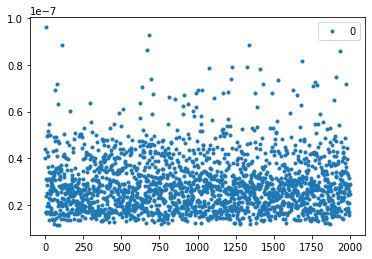

In [242]:
pd.DataFrame(all_p).plot(style='.')

<AxesSubplot:>

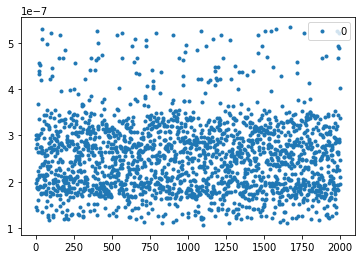

In [243]:
pd.DataFrame(all_p_if_random).plot(style='.')

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

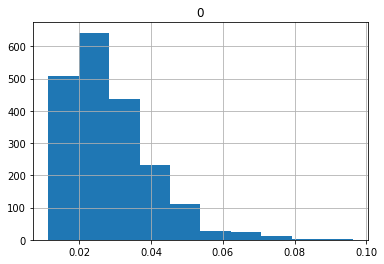

In [244]:
pd.DataFrame([x*1_000_000 for x in all_p]).hist()

In [245]:
from scipy.special import softmax


In [246]:
softmax_p = softmax(all_p)
[x for x in softmax_p]

[0.0005000000056814936,
 0.0005000000075012345,
 0.0004999999975355377,
 0.0004999999939968844,
 0.0005000000337351097,
 0.000499999993771196,
 0.0005000000010748723,
 0.0004999999941507546,
 0.0004999999937968124,
 0.0005000000103990591,
 0.0004999999997921766,
 0.0005000000068618144,
 0.0005000000010208612,
 0.0004999999952744126,
 0.0004999999981253161,
 0.0005000000106442457,
 0.0005000000036344981,
 0.0005000000011292959,
 0.0005000000113695273,
 0.0005000000061049664,
 0.000499999996076348,
 0.0004999999941726859,
 0.0005000000027211505,
 0.0004999999970841721,
 0.0004999999924535007,
 0.0005000000129219233,
 0.00049999999534319,
 0.0005000000012496711,
 0.000499999996965324,
 0.0005000000106081052,
 0.0004999999988109685,
 0.0004999999936178,
 0.0005000000010515913,
 0.0004999999980134008,
 0.0004999999988109881,
 0.0004999999997211907,
 0.000500000000409525,
 0.0005000000024853249,
 0.0004999999949563057,
 0.00049999999829799,
 0.0004999999943031989,
 0.0004999999989931806,
 0.

In [247]:
print(f"{all_p[0]:.10f}")

0.0000000401


In [248]:
print([x for x in sorted ([(x, x/0.0000002490) for x in np.array(all_p)], key=lambda x:x[1])])

[(1.1326248916760375e-08, 0.045486943440804714), (1.1326248916760375e-08, 0.045486943440804714), (1.1661664003589063e-08, 0.04683399198228539), (1.1661664003589063e-08, 0.04683399198228539), (1.1825516728241383e-08, 0.04749203505317824), (1.1867098102772621e-08, 0.047659028525191244), (1.1882575370877578e-08, 0.047721186228424), (1.1946172427495745e-08, 0.04797659609436042), (1.1946172427495745e-08, 0.04797659609436042), (1.1946172427495745e-08, 0.04797659609436042), (1.2026570290692161e-08, 0.04829947907908498), (1.206666301559911e-08, 0.048460494038550635), (1.2078422388959883e-08, 0.048507720437589885), (1.2174341913465261e-08, 0.04889293941150707), (1.2174341913465261e-08, 0.04889293941150707), (1.2197366600997895e-08, 0.04898540803613612), (1.2328917174726857e-08, 0.049513723593280545), (1.2328917174726857e-08, 0.049513723593280545), (1.2415656166294329e-08, 0.04986207295700533), (1.2453504484093224e-08, 0.050014074233306116), (1.2749030425184998e-08, 0.051200925402349384), (1.275

In [249]:
print (f"{1/4_000_000:.10f}")

0.0000002500


In [250]:
print (f"{1.1687809793205928e-08:.10f}")
print (f"{8.550671966348113e-08:.10f}")
print(f"{ 0.0000002490:.10f}")

0.0000000117
0.0000000855
0.0000002490


In [251]:
def _calculate_prefix_ditribution(values):
    return {value: occurences/len(values) for value, occurences in Counter([key[:4] for key in values]).most_common(10)}

In [252]:
_calculate_prefix_ditribution(sampled)

{'hhhh': 0.4,
 'vWIw': 0.1,
 'rrrr': 0.1,
 'AYJV': 0.1,
 'ZSZY': 0.1,
 'MPXF': 0.1,
 'gggg': 0.1}

In [283]:
print(prefix_to_percent)
_calculate_prefix_ditribution(sampled2)

{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}


{'gggg': 0.209,
 'hhhh': 0.1445,
 'mmmm': 0.11,
 'rrrr': 0.0365,
 'zsuf': 0.0005,
 'iUsC': 0.0005,
 'IQqx': 0.0005,
 'wQtU': 0.0005,
 'LdZq': 0.0005,
 'kNxh': 0.0005}

In [272]:
level_1_fanount = [len(x.child._data) for x in my_index_4m._data]
print(level_1_sizes)

[216, 144, 129, 126, 134, 169, 237]


In [279]:
level_2_fanount = [len(level_2.child._data) for level_1 in my_index_4m._data for level_2 in level_1.child._data]


In [282]:
pd.DataFrame(level_2_fanount).describe()

,0
count,"1,155.0000000000"
mean,165.2199134199
std,26.7543569718
min,125.0000000000
25%,142.0000000000
50%,161.0000000000
75%,186.0000000000
max,249.0000000000


In [299]:
[[x['path'][0][:2],x['path'][1][:2],x['path'][2][:2]] for x in sampling_ditribution if 'gggg' in x['value']]

[[(3, 7), (59, 126), (12, 183)],
 [(3, 7), (23, 126), (63, 187)],
 [(3, 7), (96, 126), (177, 207)],
 [(2, 7), (40, 129), (166, 183)],
 [(3, 7), (44, 126), (36, 206)],
 [(2, 7), (48, 129), (143, 183)],
 [(2, 7), (71, 129), (137, 173)],
 [(2, 7), (15, 129), (85, 175)],
 [(2, 7), (64, 129), (42, 183)],
 [(2, 7), (78, 129), (35, 191)],
 [(2, 7), (120, 129), (94, 187)],
 [(3, 7), (15, 126), (23, 195)],
 [(3, 7), (19, 126), (24, 185)],
 [(3, 7), (42, 126), (186, 204)],
 [(2, 7), (123, 129), (134, 202)],
 [(3, 7), (55, 126), (37, 186)],
 [(2, 7), (61, 129), (115, 185)],
 [(2, 7), (96, 129), (31, 174)],
 [(3, 7), (101, 126), (125, 187)],
 [(2, 7), (42, 129), (30, 182)],
 [(2, 7), (121, 129), (16, 201)],
 [(2, 7), (86, 129), (5, 181)],
 [(3, 7), (72, 126), (43, 179)],
 [(2, 7), (67, 129), (40, 178)],
 [(2, 7), (74, 129), (85, 178)],
 [(2, 7), (116, 129), (23, 178)],
 [(4, 7), (3, 134), (130, 189)],
 [(2, 7), (5, 129), (1, 126)],
 [(4, 7), (1, 134), (20, 199)],
 [(3, 7), (112, 126), (150, 192)],

In [297]:
sampled_pure_random = my_index_4m.random_sampling(2000, WALKING_TECHNIQUE.RANDOM)

In [298]:
print(prefix_to_percent)
_calculate_prefix_ditribution(sampled_pure_random)

{'gggg': 0.25, 'hhhh': 0.15, 'mmmm': 0.1, 'rrrr': 0.03, '': 0.47}


{'gggg': 0.2805,
 'hhhh': 0.1815,
 'mmmm': 0.09,
 'rrrr': 0.0135,
 'bQCO': 0.0005,
 'GStE': 0.0005,
 'JOZV': 0.0005,
 'RbNP': 0.0005,
 'rrOA': 0.0005,
 'LeBg': 0.0005}